In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

from bokeh.io import show, output_notebook
from bokeh.plotting import figure, gridplot
from bokeh.models import LinearAxis, Range1d
output_notebook()

Loading BokehJS ...

### GPU
指定使用的 GPU 编号。  
`watch -n 1 nvidia-smi` 实时查看 GPU 的运行状态。 

In [2]:
torch.cuda.set_device("cuda:3")
torch.cuda.current_device()
# device = torch.device("cuda:5")
# xxx.to(device)

3

### Data
通过`torchvision.datasets`下载`MNIST`数据。  
训练集：`train=True`  
测试集：`train=False`  
常用的还有`torchvision.datasets.ImageFolder()`，按文件夹取图片。  

`torchvision.transforms`可以对图片做处理。

In [3]:
train_dataset = dsets.MNIST(root='../dataset', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = dsets.MNIST(root='../dataset', train=False, transform=transforms.ToTensor(), download=True)

batch_size = 100
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=True)

### Model
用 LSTM 构造 RNN。

这里定义的 LSTM 满足 `batch_first = True`, 即输入和输出的 Tensor 的维度中，`batch_size` 要放在第一个。  
输入的 `Tensor(batch_size, seq_len, dim)`  
否则，当 `batch_first = True`，则有 `Tensor(seq_len, batch_size, dim)`，通过 `X = X.transpose(0,1)`，即交换前两维数据得到。  

作为单元组成部分的 Hidden 和 Cell 向量也有对应的维度，为 `Tensor(layer_size, batch_size, dim_hidden)`.

经过 LSTM 输出的结果，只要保留最后一个时刻的结果，即在 `seq_len` 的一栏填 `-1`. 使其成为 `Tensor(batch_size, dim)`，再通过线性网络输出。

In [4]:
class RNN(nn.Module):
    def __init__(self, dim_in, dim_hid, dim_out, layers_size):
        super().__init__()
        self.dim_hid = dim_hid
        self.layers_size = layers_size
        self.lstm = nn.LSTM(dim_in, dim_hid, layers_size, batch_first=True)
        self.fc = nn.Linear(dim_hid, dim_out)
    def forward(self, x, batch_size):
        h0 = torch.zeros(self.layers_size, batch_size, self.dim_hid).cuda()
        c0 = torch.zeros(self.layers_size, batch_size, self.dim_hid).cuda()
        x, _ = self.lstm(x, (h0, c0))
        return self.fc(x[:, -1, :])

In [5]:
lrate = 0.01
epochs = 2
sequence_length = 28
dim_in = 28
dim_hid = 128
layers_size = 2
num_classes = 10

model = RNN(dim_in, dim_hid, num_classes, layers_size).cuda()
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=lrate)
model

RNN(
  (lstm): LSTM(28, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=10, bias=True)
)

注意：每次反向传播的时候都需要将参数的梯度归零。  
`optim.step()`则在每个`Variable`的`grad`都被计算出来后，更新每个`Variable`的数值

在每次训练中都用`train_loader`中的一个`batch`作为训练数据。  
`Tensor.cuda()` 每个 `batch` 在实际使用之前，都先移入 `GPU` 后进行计算。  

In [6]:
result = []
for e in range(epochs):
    for i, (inputs, targets) in enumerate(train_loader):
        inputs = inputs.squeeze(1).cuda()
        targets = targets.cuda()
        optim.zero_grad() 
        outputs = model(inputs, batch_size)
        loss = criterion(outputs, targets)
        loss.backward()
        optim.step()
        if i % 100 == 0:
            result.append(float(loss))
fig = figure()
fig.line(range(len(result)), result)
show(fig)

### Result

`re = torch.max(Tensor,dim)`, 返回的re为一个二维向量，其中`re[0]`为最大值的`Tensor`，re[1]为最大值对应的`index`

In [7]:
correct = 0
total = 0
wrong_count = 0
wrong_classify = []
for i, (inputs, targets) in enumerate(test_loader):
    inputs = inputs.squeeze(1).cuda()
    outputs = model(inputs, 1)
    _, preds = torch.max(outputs.data, 1)
    preds = preds.cpu()
    total += len(outputs)
    correct += (preds == targets).sum()
    if wrong_count < 5 and preds != targets:
        wrong_classify.append([inputs.data, preds, targets])
        wrong_count += 1
accuracy = 100 * correct.double() / total
print('Accuracy of the model on the 10000 test images: %.2f %%' % (accuracy))

Accuracy of the model on the 10000 test images: 97.21 %


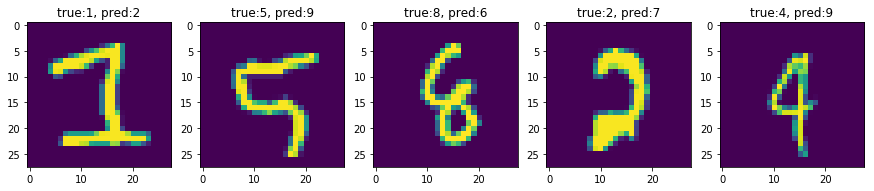

In [8]:
plt.figure(figsize=(15, wrong_count*15))
for i, (img, preds, truth) in enumerate(wrong_classify):
    img = img.reshape(28, 28).cpu().numpy()
    plt.subplot(1, wrong_count, i+1)
    plt.imshow(img)
    plt.title('true:%i, pred:%i' % (truth, preds))
plt.show()

### Save Model

In [9]:
torch.save(model.state_dict(), 'rnn_cuda.pkl')